# Tutorial to run the variable-coefficient KdV (vKdV) model (with rotation, rvKdV)

This tutorial gives a background on running the vKdV model to track the evolution of an internal wave in an ocean with continuous density stratification. The model equation is

$$
\frac{\partial A}{\partial t} + c(x) \frac{\partial A}{\partial x} + \alpha(x) A \frac{\partial A}{\partial x} +\beta(x) \frac{\partial^3 A}{\partial x^3}
+ \frac{c(x)}{2Q(x)}\frac{\partial Q}{\partial x}A\ = \int_{-\infty}^{x}\frac{f^2}{2c}A\ dx'
$$

where the solution $A(x,t)$ is the wave amplitude (roughly the displacement of an isopycnal within the pycnocline for a mode-1 internal wave).

How to:

  - Create initial stratification and bathymetry
  - Initialise a `KdV` class
  - Inspect the KdV parameters
  - Specifify boundary conditions
  - Run a model
  - Inspect the results
  
---

Matt Rayson

University of Western Australia

March 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iwaves.kdv.vkdv import  vKdV 

In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

# Specify the horizontal domain and create a bathymetry section

We use an analytical profile of a smooth shelf break represented with a tanh function.

In [3]:
def depth_tanh(beta, x):
    """
    Hyperbolic tangent shelf break

    H - total depth
    h0 - shelf height
    x0 - shelf break x location
    lt - shelf break width
    """
    
    H, h0, x0, lt = beta

    return H-0.5*h0*(1+np.tanh((x-x0)/(0.5*lt)))

(-600.0, 0.0)

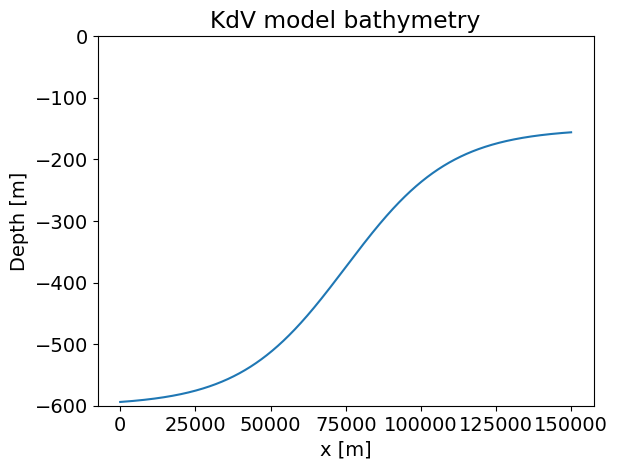

In [4]:
# Model parameters
N = 3000 # Number of grid points
dx = 50. # horizontal grid spacing

H = 600
h0 = 450
bathy_params = [H, h0, 75e3, 70e3]  # See the depth_tanh function for the mean

# The horizontal domain
x = np.arange(0, N*dx, dx)

# The depth
h = depth_tanh(bathy_params, x) 

plt.figure()
plt.plot(x, -h)
plt.title('KdV model bathymetry')
plt.ylabel('Depth [m]')
plt.xlabel('x [m]')
plt.ylim(-H, 0)

# Specify the vertical density profile

We use a double hyperbolic tangent to represent density profile. This is a good approximation for some regions of the upper ocean. See e.g.,

- Manderson, A, M. D. Rayson, E. Cripps, M. Girolami, J. P. Gosling, M. Hodkiewicz, N. L. Jones, G. N. Ivey, (2019) Uncertainty quantification of density and stratification estimates with implications for predicting ocean dynamics, *Journal of Atmospheric and Oceanic Technology*, [https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1](https://journals.ametsoc.org/doi/full/10.1175/JTECH-D-18-0200.1)
- Rayson, M. D., N. L. Jones and G. N. Ivey (2019), Observations of large amplitude mode-2 nonlinear internal waves on the Australian North West Shelf, *Journal of Physical Oceanography*, [https://doi.org/10.1175/JPO-D-18-0097.1](https://doi.org/10.1175/JPO-D-18-0097.1)




In [5]:
def rho_double_tanh(beta, z):
    """
    Double hyperbolic tangent density profile model
    """
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
        + np.tanh((z+beta[4])/beta[5]))


Text(0.5, 0, 'Density [kg m$^{-3}$]')

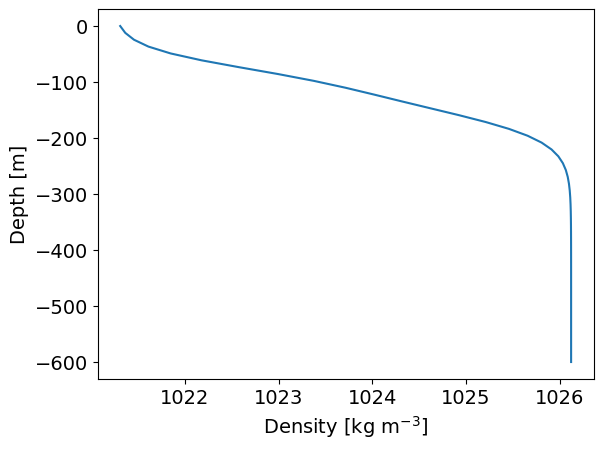

In [6]:
# See the references above for the mean of the
rho_params =[1023.68, # Mean density
     1.22, # Density jump
     156.7, # Depth of the first pycnocline
     53.6,# Width of the first pycnocline
     73.1,# Depth of the first pycnocline
     40.2, # Width of the second pycnocline
        ] 

# Number of vertical levels
Nz = 50

z = np.linspace(-H,0,Nz)
rhoz = rho_double_tanh(rho_params,z)

plt.figure()
plt.plot(rhoz, z)
plt.ylabel('Depth [m]')
plt.xlabel('Density [kg m$^{-3}$]')

# Initialise the KdV model

This requires the density profile and bathymetric section plus a few other model inputs. This does not solve the equation; it only calculates the input parameters e.g. nonlinearity, linear phase speed.

In [7]:
# IMEX options (These are weights for the numerical time integration scheme)
imex={
        'MCN_AX2':(1/8., 3/8.),
        'AM2_AX2':(1/2., 1/2.),
        'AI2_AB3':(3/2., 5/6.),
        'BDF2_BX2':(0.,0.),
        'BDF2_BX2s':(0.,1/2.),
        'BI2_BC3':(1/3.,2/3.),
}


In [8]:

dt = 15.
mode = 0 # Mode=0 corresponds to mode-1 waves
imexscheme = 'AM2_AX2'
c_im = imex[imexscheme][0]
b_ex = imex[imexscheme][1]

kdvargs = dict(
   N=N,
   dx=dx,
   dt=dt,
   spongedist = 20e3,
   spongetime = 360.,
   Nsubset = 10,
   nonhydrostatic=1.,
   nonlinear=1.,
   c_im=c_im,
   b_ex=b_ex,
   verbose=True,
)

## Initialise the class
mykdv = vKdV(rhoz, z, h, x, mode, **kdvargs)


Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


# Inspect the KdV model parameters

Text(0, 0.5, 'Linear amplification "Q"')

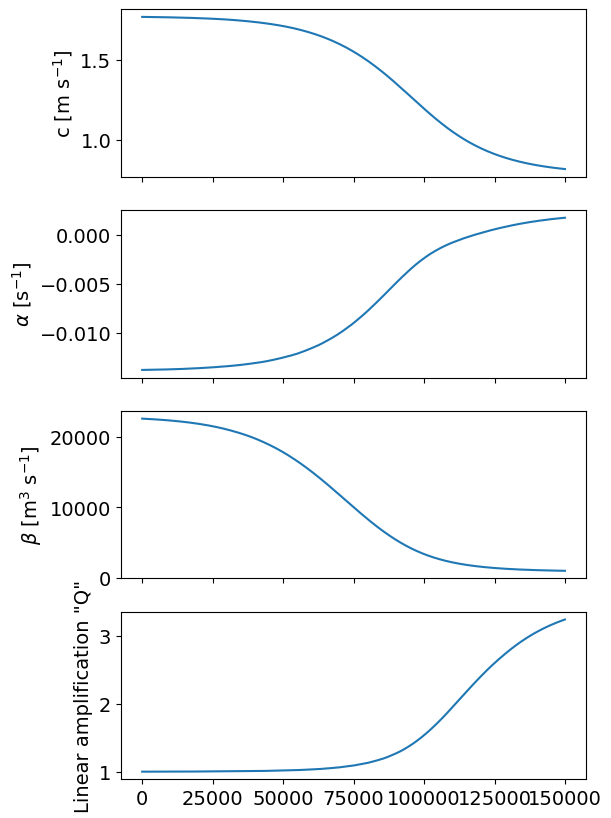

In [9]:
# Plot some of the environmental parameters as a function of distance
plt.figure(figsize=(6,10))
ax1=plt.subplot(411)
ax1.plot(mykdv.x, mykdv.c)
plt.ylabel('c [m s$^{-1}$]')
ax1.set_xticklabels([])
ax2=plt.subplot(412)
ax2.plot(mykdv.x, mykdv.alpha)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
ax2.set_xticklabels([])

ax3=plt.subplot(413)
ax3.plot(mykdv.x, mykdv.beta)
plt.ylabel(r'$\beta$ [m$^3$ s$^{-1}$]')
ax3.set_xticklabels([])

ax2=plt.subplot(414)
ax2.plot(mykdv.x, 1/mykdv.Q)
plt.ylabel(r'Linear amplification "Q"')


Text(0, 0.5, 'Depth [m]')

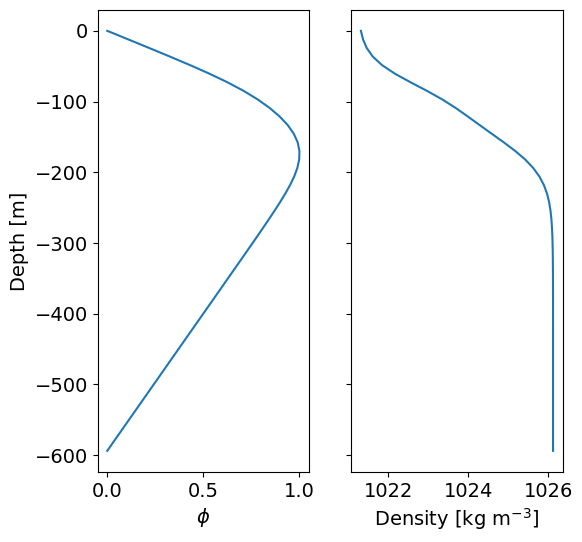

In [10]:
# Plot the density profile and vertical eigenfunction
plt.figure(figsize=(6,6))
ax1=plt.subplot(121)
ax1.plot(mykdv.Phi[:,0],mykdv.Z[:,0], )
plt.xlabel('$\phi$')

ax2=plt.subplot(122)
ax2.plot(mykdv.rhoZ[:,0],mykdv.Z[:,0], )
plt.xlabel('Density [kg m$^{-3}$]')
ax2.set_yticklabels([])
ax1.set_ylabel('Depth [m]')

Text(0, 0.5, 'Depth [m]')

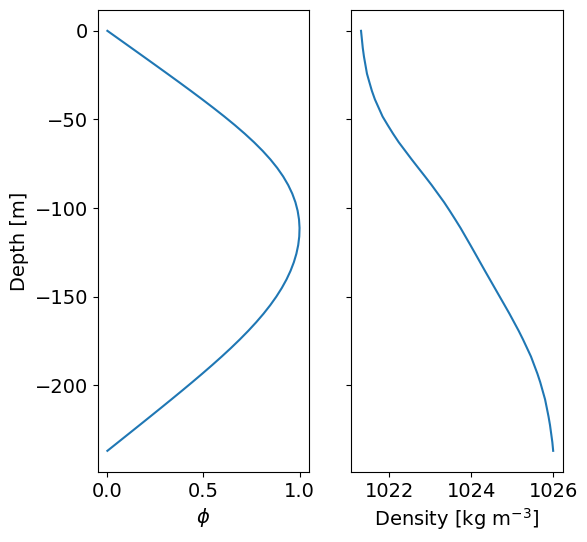

In [11]:
# Plot the density profile and vertical eigenfunction (upstream)
plt.figure(figsize=(6,6))
ax1=plt.subplot(121)
ax1.plot(mykdv.Phi[:,2000],mykdv.Z[:,2000], )
plt.xlabel('$\phi$')

ax2=plt.subplot(122)
ax2.plot(mykdv.rhoZ[:,2000],mykdv.Z[:,2000], )
plt.xlabel('Density [kg m$^{-3}$]')
ax2.set_yticklabels([])
ax1.set_ylabel('Depth [m]')

# Specify a boundary condition

Use a sine wave boundary condition

In [12]:
def bcfunc(a0, period, t):
    omega = 2*np.pi/period
    return a0*np.sin(omega*t)

Text(0.5, 0, 't [s]')

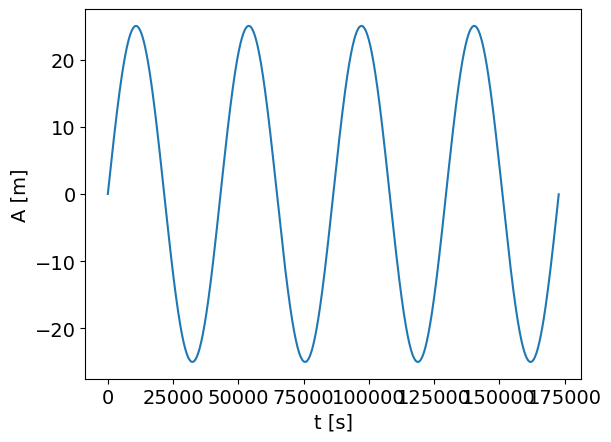

In [13]:
# Specify the runtime in seconds
runtime = 2*86400 # 3 days
ntout = 600//dt # how often to output the model solution

# Boundary condition parameters
a0 = 25.
period = 12*3600.

# Number of time steps to run
nsteps = int(runtime//dt)

# Plot up the boundary function
t = np.arange(0, nsteps*dt, dt)
plt.figure()

plt.plot(t, bcfunc(a0, period, t))
plt.ylabel('A [m]')
plt.xlabel('t [s]')

# Run the model...

In [14]:
t=[]
A=[]
mykdv.t=0
for ii in range(nsteps):
    if ii%ntout==0:
        # Store snapshots of the solution every "ntout" steps
        t.append(mykdv.t)
        A.append(mykdv.B_n_p1*1) # the solution is stored as the "B_n_p1" 
        
    if mykdv.solve_step(bc_left=bcfunc(a0,period,mykdv.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break
        

        
t = np.array(t)
A = np.array(A)

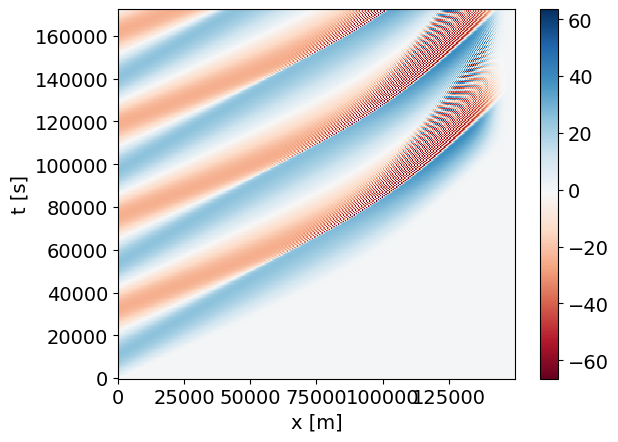

In [15]:
#"x-t"/Hovmoller plot of the solution

plt.figure()
plt.pcolormesh(x, t, A, cmap='RdBu')
plt.ylabel('t [s]')
plt.xlabel('x [m]')
plt.colorbar()

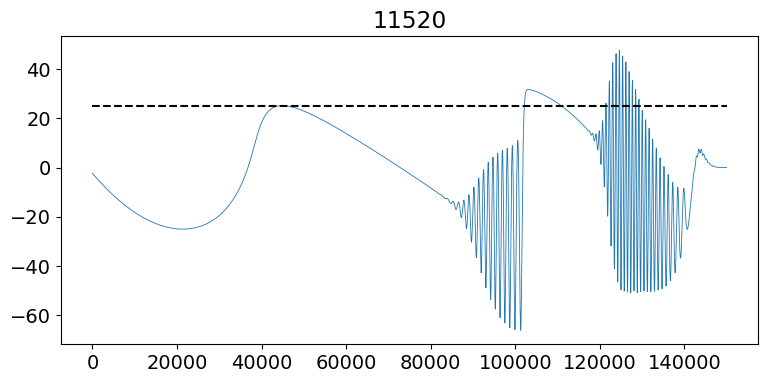

In [16]:
plt.figure(figsize=(9,4))
plt.plot(x,A[-1,:], lw=0.6)
# plt.plot(x,myrkdv.B_n_p1, lw=0.3)
# plt.legend(('KdV','rKdV'))
plt.plot([x[0],x[-1]],[a0,a0],'k--')
plt.title(nsteps)
plt.show()

# Run rvKdV

In [17]:
# """
# class rvKdV(vKdV):
#     def __init__(self, rhoz, z, h, x, mode, cor_f=0, **kwargs):
#         """
#         Variable-coefficient KdV with rotation
#         """
#         self.cor_f = cor_f
#         vKdV.__init__(self, rhoz, z, h, x, mode, **kwargs)

#     def calc_nonlinear_rhs(self, A):
#         """
#         Calculate the nonlinear steepening term vectors

#         RHS of the rotation equation is:
#         $$
#         \int_{-\infty}^{x}\frac{f^2}{2c}A\ dx'
#         $$
#         """
#         rhs = vKdV.calc_nonlinear_rhs(self, A)

#         cff = 0.5*self.cor_f*self.cor_f / self.c 

#         rhs -= np.cumsum(cff * A * self.dx)

#         return rhs
# """

from iwaves.kdv.rvkdv import  rvKdV 

In [18]:
cor_f = 3.5e-5
myrkdv = rvKdV(rhoz, z, h, x, mode, cor_f=cor_f, **kdvargs)


t=[]
Ar=[]
myrkdv.t=0
for ii in range(nsteps):
    if ii%ntout==0:
        # Store snapshots of the solution every "ntout" steps
        t.append(myrkdv.t)
        Ar.append(myrkdv.B_n_p1*1) # the solution is stored as the "B_n_p1" 
        
    if myrkdv.solve_step(bc_left=bcfunc(a0,period,myrkdv.t)) != 0:
        print('Blowing up at step: %d'%ii)
        break
        

        
t = np.array(t)
Ar = np.array(Ar)

Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...


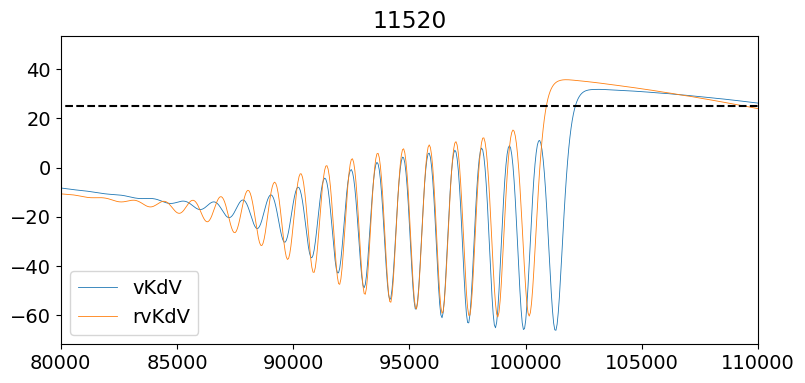

In [19]:
plt.figure(figsize=(9,4))
plt.plot(x,A[-1,:], lw=0.6)
plt.plot(x,Ar[-1,:], lw=0.6)

# plt.plot(x,myrkdv.B_n_p1, lw=0.3)
plt.legend(('vKdV','rvKdV'))
plt.plot([x[0],x[-1]],[a0,a0],'k--')
plt.xlim(8e4, 11e4)
plt.title(nsteps)
plt.show()